In [1]:
# importing libraries & modules
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

## Loading stock data
---

In [2]:
google = yf.Ticker("GOOGL")
google_data = google.history(period="1y")

## Visualizing stock price data over time
---

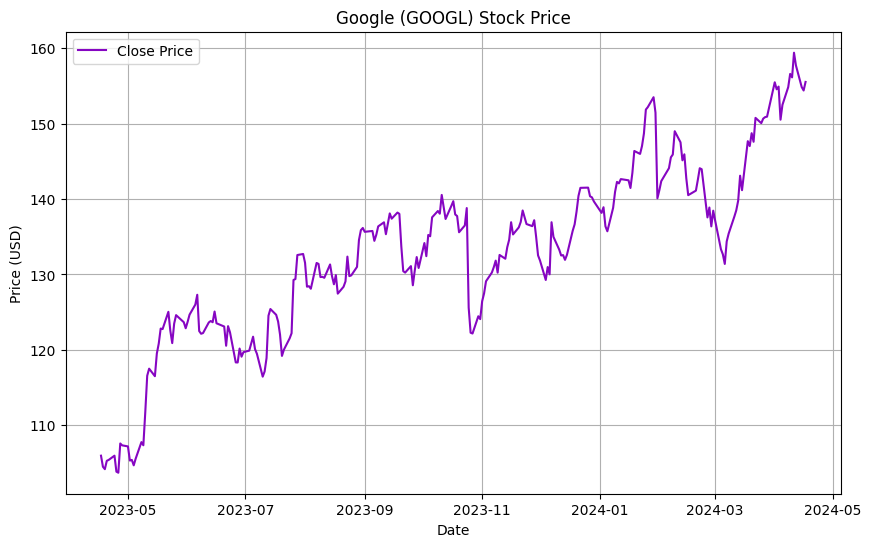

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(google_data['Close'], label='Close Price', color='#8606c2')
plt.title('Google (GOOGL) Stock Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
close_price = google_data['Close']

In [5]:
close_price.shift(1)

Date
2023-04-17 00:00:00-04:00           NaN
2023-04-18 00:00:00-04:00    105.970001
2023-04-19 00:00:00-04:00    104.500000
2023-04-20 00:00:00-04:00    104.180000
2023-04-21 00:00:00-04:00    105.290001
                                ...    
2024-04-11 00:00:00-04:00    156.139999
2024-04-12 00:00:00-04:00    159.410004
2024-04-15 00:00:00-04:00    157.729996
2024-04-16 00:00:00-04:00    154.860001
2024-04-17 00:00:00-04:00    154.399994
Name: Close, Length: 253, dtype: float64

In [6]:
returns = ((close_price - close_price.shift(1)) / close_price.shift(1)).dropna()
annual_volatility = np.std(returns) * np.sqrt(252)

print(f'Annual Volatility : {annual_volatility}')

Annual Volatility : 0.26953289049620693


##  Using 10 years' US treasury rate as the rate of interest
---

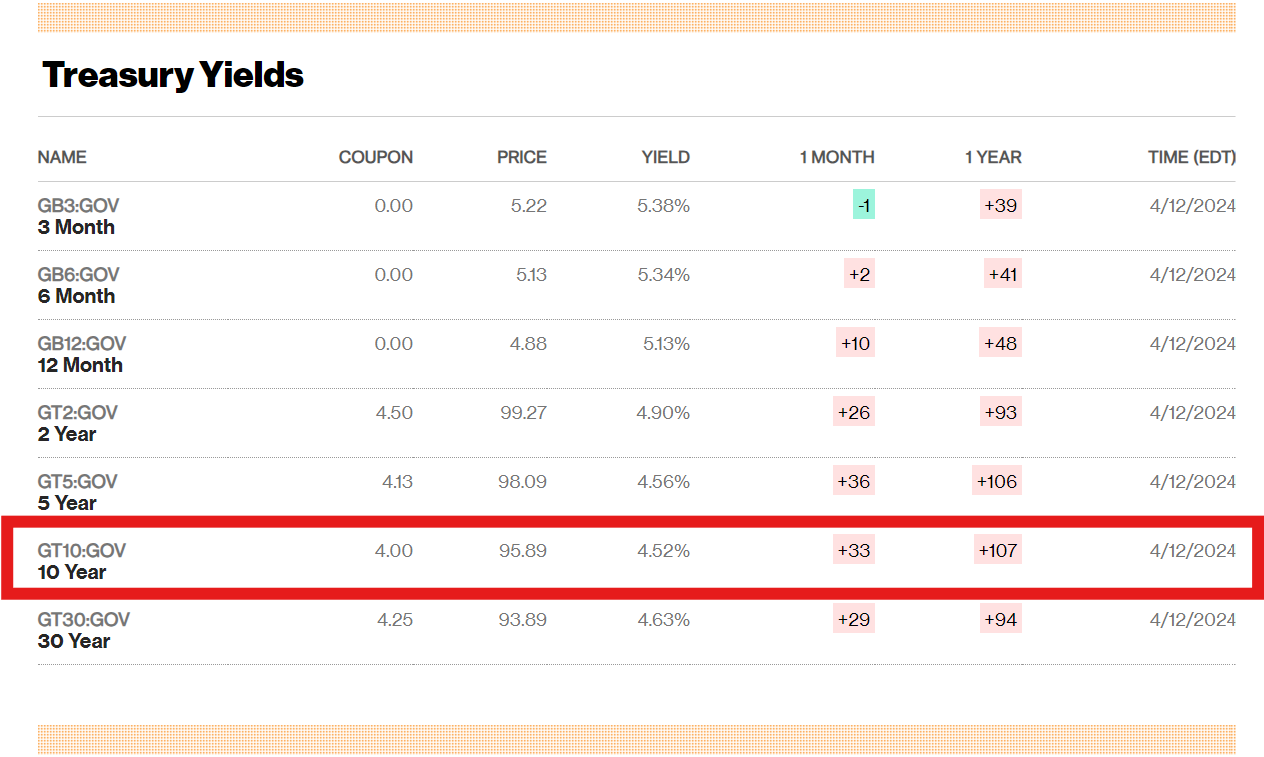

In [7]:
rate_of_interest = 4.52 / 100

In [8]:
def put_call_parity(C0, K, T, r, S0):
    '''
    returns put option price based on put-call parity
    '''
    P0 = C0 - S0 + K * np.exp(-r * T)
    return P0

## Evaluating the call / put option prices by using Binomial model
---

In [9]:
def binomial_option_pricing(S0, K, T, r, σ, n, option_type):
    """
    Calculates the option price using the Binomial option pricing model.
    -----------------
    
    Args:
        S0 (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity in years
        r (float): Risk-free interest rate
        σ (float): Annual volatility of the underlying asset
        n (int): Number of time steps
        option_type (str): 'call' or 'put'
        
    Returns:
        float: Option price
    """
    
    Δt = T / n
    u = math.exp(σ * math.sqrt(Δt))
    d = 1 / u
    p = (math.exp(r * Δt) - d) / (u - d)
    
    option_price = 0
    
    for j in range(0, n + 1):
        price_component = S0 * (u ** j) * (d ** (n - j)) - K
        prob_component = math.comb(n, j) * (p ** j) * ((1 - p) ** (n - j))
     
        if option_type == 'call':
            price = prob_component * max(0, price_component)
        elif option_type == 'put':
            price = prob_component * max(0, -price_component)
        
        option_price += price
        
    option_price = math.exp(-r * T) * option_price
    return option_price

In [10]:
S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
n = 2    # number of time steps
T = 1
K = 100

In [11]:
call_option_price = binomial_option_pricing(S0, K, T, r, σ, n, 'call')
print(f'Call option price using Binomial model : {call_option_price}')

Call option price using Binomial model : 16.672835927077156


In [12]:
put_option_price = binomial_option_pricing(S0, K, T, r, σ, n, 'put')
print(f'Put option price using Binomial model : {put_option_price}')

Put option price using Binomial model : 6.283464851914842


In [13]:
C0, K, T, r, S0 = call_option_price, K, T, r, S0
put_option_price = put_call_parity(C0, K, T, r, S0)
print(f'Put option price using put call parity : {put_option_price}')

Put option price using put call parity : 6.2834648519148715


## Evaluating the call / put option prices by using Black Scholes formula
---

In [14]:
def black_scholes_formula(S0, K, T, r, σ, option_type):
    '''
    Calculates the option price using the Black Scholes formula.
    -----------------
    
    Args:
        S0 (float): Current stock price
        K (float): Strike price
        T (float): Time to maturity in years
        r (float): Risk-free interest rate
        σ (float): Annual volatility of the underlying asset
        option_type (str): 'call' or 'put'
        
    Returns:
        float: Option price
    '''
    d1 = (math.log(S0 / K) + (r + (σ ** 2) / 2) * T) / (σ * math.sqrt(T))
    d2 = d1 - σ * math.sqrt(T)
    
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    C0 = S0 * N_d1 - K * math.exp(-r * T) * N_d2
    if option_type == 'call':
        return C0
    elif option_type == 'put':
        P0 = put_call_parity(C0, K, T, r, S0)
        return P0

In [15]:
S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
T = 1
K = 100

In [16]:
call_option_price = black_scholes_formula(S0, K, T, r, σ, 'call')
print(f'Call option price using Black Scholes formula : {call_option_price}')

Call option price using Black Scholes formula : 16.774715747369072


In [17]:
put_option_price = black_scholes_formula(S0, K, T, r, σ, 'put')
print(f'Put option price using Black Scholes formula : {put_option_price}')

Put option price using Black Scholes formula : 6.385344672206784


## Evaluating option prices
---

In [18]:
K_vals = S0 + np.arange(-20, 20, 3)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
n = 2    # number of time steps

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        call_option_price = binomial_option_pricing(S0, K, T, r, σ, n, 'call')
        print(f'T = {int(T * 12)} month(s) : Call Option price is {call_option_price}')

For K = 85.97000122070312
T = 1 month(s) : Call Option price is 20.323211241289542
T = 5 month(s) : Call Option price is 22.344701077877914
T = 9 month(s) : Call Option price is 25.13516453077245
For K = 88.97000122070312
T = 1 month(s) : Call Option price is 17.334489986318047
T = 5 month(s) : Call Option price is 20.114364431590513
T = 9 month(s) : Call Option price is 22.930372365545647
For K = 91.97000122070312
T = 1 month(s) : Call Option price is 14.345768731346553
T = 5 month(s) : Call Option price is 17.88402778530311
T = 9 month(s) : Call Option price is 20.725580200318845
For K = 94.97000122070312
T = 1 month(s) : Call Option price is 11.367344467968142
T = 5 month(s) : Call Option price is 15.653691139015708
T = 9 month(s) : Call Option price is 18.520788035092046
For K = 97.97000122070312
T = 1 month(s) : Call Option price is 9.11575962858155
T = 5 month(s) : Call Option price is 13.423354492728306
T = 9 month(s) : Call Option price is 16.315995869865244
For K = 100.9700012

In [19]:
K_vals = S0 + np.arange(-20, 20, 3)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
n = 2    # number of time steps

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        put_option_price = binomial_option_pricing(S0, K, T, r, σ, n,'put')
        print(f'T = {int(T * 12)} month(s) : Put Option price is {put_option_price}')

For K = 85.97000122070312
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 0.7407506636996947
T = 9 month(s) : Put Option price is 2.2696267744905785
For K = 88.97000122070312
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 1.454442734706576
T = 9 month(s) : Put Option price is 2.9648391091267445
For K = 91.97000122070312
T = 1 month(s) : Put Option price is 0.0
T = 5 month(s) : Put Option price is 2.1681348057134575
T = 9 month(s) : Put Option price is 3.6600514437629106
For K = 94.97000122070312
T = 1 month(s) : Put Option price is 0.010296991593082646
T = 5 month(s) : Put Option price is 2.8818268767203388
T = 9 month(s) : Put Option price is 4.355263778399077
For K = 97.97000122070312
T = 1 month(s) : Put Option price is 0.7474334071779873
T = 5 month(s) : Put Option price is 3.59551894772722
T = 9 month(s) : Put Option price is 5.050476113035243
For K = 100.97000122070312
T = 1 month(s) : Put Option price is 1.484569822762

In [20]:
K_vals = S0 + np.arange(-20, 20, 3)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        call_option_price = black_scholes_formula(S0, K, T, r, σ, 'call')
        print(f'T = {int(T * 12)} month(s) : Put Option price is {call_option_price}')

For K = 85.97000122070312
T = 1 month(s) : Put Option price is 20.33017538931108
T = 5 month(s) : Put Option price is 22.334548579727326
T = 9 month(s) : Put Option price is 24.544202366269133
For K = 88.97000122070312
T = 1 month(s) : Put Option price is 17.362432715291305
T = 5 month(s) : Put Option price is 19.77568764102685
T = 9 month(s) : Put Option price is 22.217493654912914
For K = 91.97000122070312
T = 1 month(s) : Put Option price is 14.437423302076724
T = 5 month(s) : Put Option price is 17.351084879041636
T = 9 month(s) : Put Option price is 20.014126743398833
For K = 94.97000122070312
T = 1 month(s) : Put Option price is 11.608599175985503
T = 5 month(s) : Put Option price is 15.081477445149545
T = 9 month(s) : Put Option price is 17.942668616692387
For K = 97.97000122070312
T = 1 month(s) : Put Option price is 8.958524708168781
T = 5 month(s) : Put Option price is 12.983972009323338
T = 9 month(s) : Put Option price is 16.009307435781075
For K = 100.97000122070312
T = 1 

In [21]:
K_vals = S0 + np.arange(-20, 20, 3)
T_vals = [num_months * (1 / 12) for num_months in range(1, 13, 4)]

S0 = google_data['Close'][0]    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate

for K in K_vals:
    print(f'For K = {K}')
    for T in T_vals:
        put_option_price = black_scholes_formula(S0, K, T, r, σ, 'put')
        print(f'T = {int(T * 12)} month(s) : Put Option price is {put_option_price}')

For K = 85.97000122070312
T = 1 month(s) : Put Option price is 0.006964148021552319
T = 5 month(s) : Put Option price is 0.7305981655490967
T = 9 month(s) : Put Option price is 1.678664609987294
For K = 88.97000122070312
T = 1 month(s) : Put Option price is 0.027942728973272324
T = 5 month(s) : Put Option price is 1.1157659441429075
T = 9 month(s) : Put Option price is 2.2519603984940346
For K = 91.97000122070312
T = 1 month(s) : Put Option price is 0.09165457073018501
T = 5 month(s) : Put Option price is 1.6351918994519679
T = 9 month(s) : Put Option price is 2.948597986842927
For K = 94.97000122070312
T = 1 month(s) : Put Option price is 0.2515516996104594
T = 5 month(s) : Put Option price is 2.3096131828541644
T = 9 month(s) : Put Option price is 3.777144359999454
For K = 97.97000122070312
T = 1 month(s) : Put Option price is 0.5901984867652317
T = 5 month(s) : Put Option price is 3.1561364643222447
T = 9 month(s) : Put Option price is 4.743787678951094
For K = 100.97000122070312
T 

In [22]:
S0 = 200    # current stock price
σ = annual_volatility    # annual volatility
r = rate_of_interest    # interest rate
T = 2
K = 220

black_scholes_call_price = black_scholes_formula(S0, K, T, r, σ, 'call')
print(f'Black Scholes Call Option Price : {black_scholes_call_price}')

call_prices = []

for n in range(1, 100):
    call_price = binomial_option_pricing(S0, K, T, r, σ, n, 'call')
    call_prices.append(call_price)

Black Scholes Call Option Price : 29.81506470436736


## Increasing the number of steps in Binomial model to verify that the price converges to that of Black Scholes
---

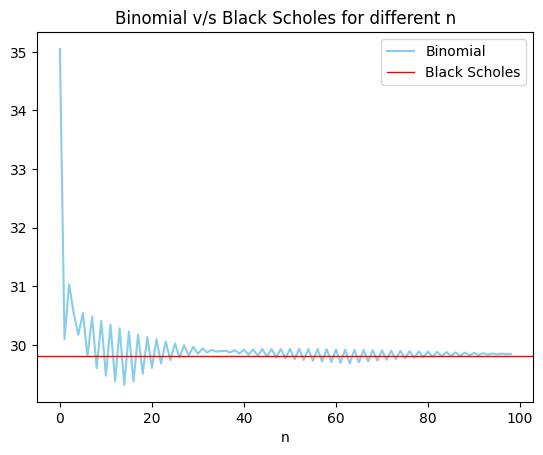

In [23]:
plt.plot(call_prices, label='Binomial', color='skyblue')
plt.axhline(black_scholes_call_price, color='red', label='Black Scholes', linewidth=1)
plt.xlabel('n')

plt.title('Binomial v/s Black Scholes for different n')
plt.legend()
plt.show()

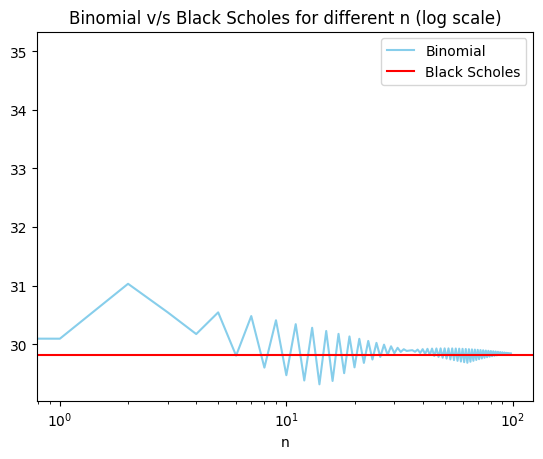

In [24]:
plt.plot(call_prices, label='Binomial', color='skyblue')
plt.axhline(black_scholes_call_price, color='red', label='Black Scholes')
plt.xlabel('n')

plt.legend()
plt.xscale('log')
plt.title('Binomial v/s Black Scholes for different n (log scale)')
plt.show()

## Comparison with actual market data
---

In [25]:
ticker_symbol = "GOOGL"
options_data = yf.Ticker(ticker_symbol).options
expiry_date = options_data[0]
options_chain = yf.Ticker(ticker_symbol).option_chain(expiry_date)

calls = pd.DataFrame(options_chain.calls)
puts = pd.DataFrame(options_chain.puts)

In [26]:
try:
    calls.drop(['contractSymbol' , 'bid' , 'ask' , 'change' , 'percentChange' , 'volume' , 'openInterest' , 'inTheMoney'],axis=1 , inplace=True)
    puts.drop(['contractSymbol' , 'bid' , 'ask' , 'change' , 'percentChange' , 'volume' , 'openInterest' , 'inTheMoney'], axis=1 , inplace=True)
except Exception as e:
    print(e)

### Call Option Comparison

In [27]:
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-04-16 18:34:21+00:00,5.0,149.80,12.500002,REGULAR,USD
1,2024-02-27 19:16:26+00:00,35.0,103.96,0.000010,REGULAR,USD
2,2024-04-15 13:56:50+00:00,45.0,113.44,0.000010,REGULAR,USD
3,2024-04-04 18:52:10+00:00,50.0,102.50,5.839846,REGULAR,USD
4,2024-03-04 20:51:01+00:00,55.0,78.69,0.000010,REGULAR,USD


In [28]:
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.date
start_date, end_date = "2023-03-28", "2024-04-01"
calls = calls[(calls['lastTradeDate'] >= pd.to_datetime(start_date).date()) & (calls['lastTradeDate'] <= pd.to_datetime(end_date).date())]
calls.reset_index(inplace = True, drop = True)
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-02-27,35.0,103.96,0.00001,REGULAR,USD
1,2024-03-04,55.0,78.69,0.00001,REGULAR,USD
2,2024-03-04,60.0,73.89,0.00001,REGULAR,USD
3,2023-11-17,65.0,70.70,0.00001,REGULAR,USD
4,2024-03-07,75.0,59.73,0.00001,REGULAR,USD


In [29]:
google_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-17 00:00:00-04:00,104.660004,106.160004,104.519997,105.970001,37571200,0.0,0.0
2023-04-18 00:00:00-04:00,106.489998,106.540001,104.070000,104.500000,26596400,0.0,0.0
2023-04-19 00:00:00-04:00,103.580002,104.980003,103.070000,104.180000,20905700,0.0,0.0
2023-04-20 00:00:00-04:00,103.910004,106.250000,103.870003,105.290001,27820800,0.0,0.0
2023-04-21 00:00:00-04:00,105.470001,106.000000,104.779999,105.410004,25800100,0.0,0.0


In [30]:
google_data.index = pd.to_datetime(google_data.index)
google_data.index = google_data.index.strftime("%Y-%m-%d")
google_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-17,104.660004,106.160004,104.519997,105.970001,37571200,0.0,0.0
2023-04-18,106.489998,106.540001,104.070000,104.500000,26596400,0.0,0.0
2023-04-19,103.580002,104.980003,103.070000,104.180000,20905700,0.0,0.0
2023-04-20,103.910004,106.250000,103.870003,105.290001,27820800,0.0,0.0
2023-04-21,105.470001,106.000000,104.779999,105.410004,25800100,0.0,0.0


In [31]:
expiry_date = pd.to_datetime(expiry_date).date()
expiry_date

datetime.date(2024, 4, 19)

In [32]:
initialPrice_call = []
for date in calls['lastTradeDate']:
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    initialPrice_call.append(initialPrice)
calls['initialPrice'] = initialPrice_call

In [33]:
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice
0,2024-02-27,35.0,103.96,0.00001,REGULAR,USD,138.880005
1,2024-03-04,55.0,78.69,0.00001,REGULAR,USD,133.350006
2,2024-03-04,60.0,73.89,0.00001,REGULAR,USD,133.350006
3,2023-11-17,65.0,70.70,0.00001,REGULAR,USD,135.309998
4,2024-03-07,75.0,59.73,0.00001,REGULAR,USD,134.380005


In [34]:
maturity_periods_call = []
for i in calls['lastTradeDate']:
    maturity_period = (expiry_date - i).days
    maturity_periods_call.append(maturity_period)

In [35]:
calls['maturityPeriod'] = maturity_periods_call
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod
0,2024-02-27,35.0,103.96,0.00001,REGULAR,USD,138.880005,52
1,2024-03-04,55.0,78.69,0.00001,REGULAR,USD,133.350006,46
2,2024-03-04,60.0,73.89,0.00001,REGULAR,USD,133.350006,46
3,2023-11-17,65.0,70.70,0.00001,REGULAR,USD,135.309998,154
4,2024-03-07,75.0,59.73,0.00001,REGULAR,USD,134.380005,43


In [36]:
option_price_binomial = []
for i in range(len(calls)):
    T = calls['maturityPeriod'][i]/365
    n = calls['maturityPeriod'][i]
    K = calls['strike'][i]
    S0 = calls['initialPrice'][i]
    op_price = binomial_option_pricing(S0, K, T, r, σ, n, "call")
    option_price_binomial.append(op_price)

In [37]:
calls['optionPriceBinomial'] = option_price_binomial
calls

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial
0,2024-02-27,35.0,103.96,0.000010,REGULAR,USD,138.880005,52,1.041047e+02
1,2024-03-04,55.0,78.69,0.000010,REGULAR,USD,133.350006,46,7.866242e+01
2,2024-03-04,60.0,73.89,0.000010,REGULAR,USD,133.350006,46,7.369082e+01
3,2023-11-17,65.0,70.70,0.000010,REGULAR,USD,135.309998,154,7.153787e+01
4,2024-03-07,75.0,59.73,0.000010,REGULAR,USD,134.380005,43,5.977831e+01
5,2024-03-26,90.0,62.13,0.000010,REGULAR,USD,150.669998,24,6.093709e+01
6,2024-04-01,127.0,28.37,0.812502,REGULAR,USD,155.490005,18,2.877300e+01
7,2024-03-26,215.0,0.01,1.156254,REGULAR,USD,150.669998,24,0.000000e+00
8,2024-03-19,220.0,0.01,1.218754,REGULAR,USD,147.029999,31,2.424864e-08
9,2024-03-20,225.0,0.02,1.312503,REGULAR,USD,148.740005,30,2.062805e-09


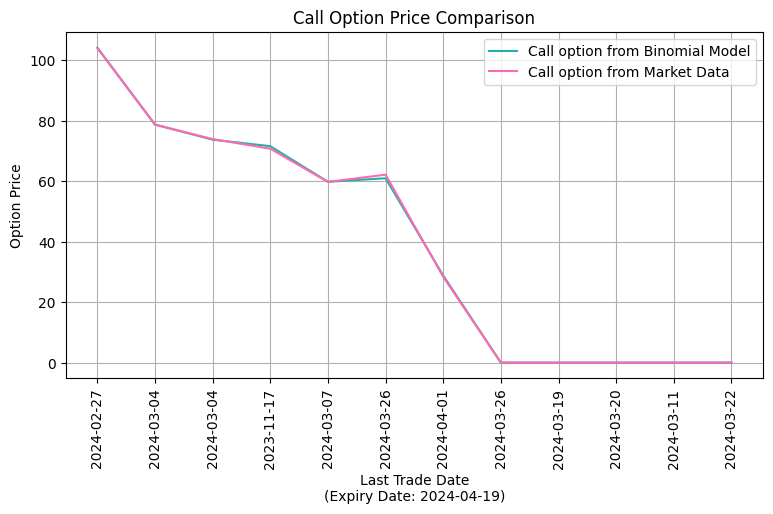

In [38]:
plt.figure(figsize=(9, 4.5))
plt.plot(calls.index, calls['optionPriceBinomial'], label='Call option from Binomial Model', c='lightseagreen')
plt.plot(calls.index, calls['lastPrice'], label='Call option from Market Data', c='hotpink')
plt.title('Call Option Price Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

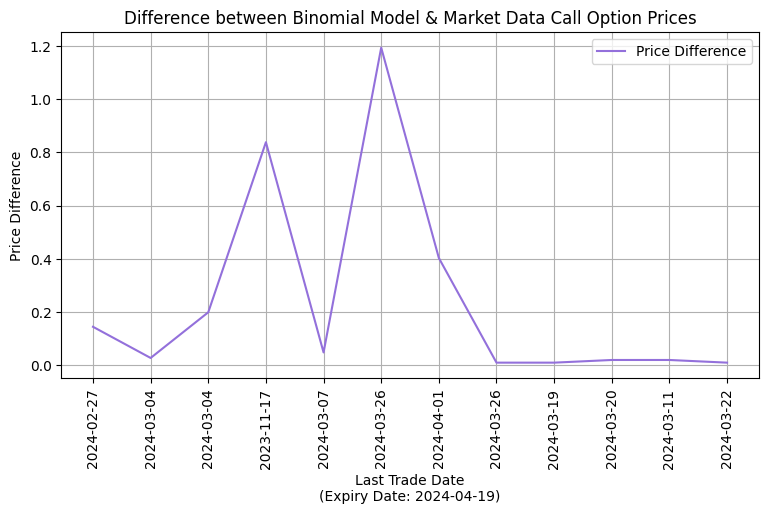

In [39]:
plt.figure(figsize=(9, 4.5))
differences = abs(calls['optionPriceBinomial'] - calls['lastPrice'])
plt.plot(range(len(calls)), differences, label='Price Difference', c='mediumpurple')
plt.title('Difference between Binomial Model & Market Data Call Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

In [40]:
option_price_black_scholes = []
for i in range(len(calls)):
    T = calls['maturityPeriod'][i]/365
    n = calls['maturityPeriod'][i]
    K = calls['strike'][i]
    S0 = calls['initialPrice'][i]
    op_price = black_scholes_formula(S0, K, T, r, σ, "call")
    option_price_black_scholes.append(op_price)

In [41]:
calls['optionPriceBlackScholes'] = option_price_black_scholes
calls.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial,optionPriceBlackScholes
0,2024-02-27,35.0,103.96,0.00001,REGULAR,USD,138.880005,52,104.104662,104.104662
1,2024-03-04,55.0,78.69,0.00001,REGULAR,USD,133.350006,46,78.662420,78.662420
2,2024-03-04,60.0,73.89,0.00001,REGULAR,USD,133.350006,46,73.690821,73.690821
3,2023-11-17,65.0,70.70,0.00001,REGULAR,USD,135.309998,154,71.537871,71.537877
4,2024-03-07,75.0,59.73,0.00001,REGULAR,USD,134.380005,43,59.778313,59.778313


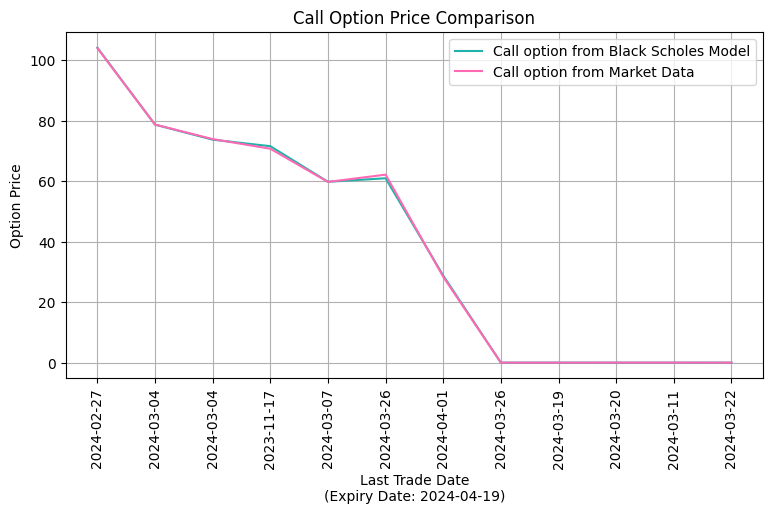

In [42]:
plt.figure(figsize=(9, 4.5))
plt.plot(calls.index, calls['optionPriceBlackScholes'], label='Call option from Black Scholes Model', c='lightseagreen')
plt.plot(calls.index, calls['lastPrice'], label='Call option from Market Data', c='hotpink')
plt.title('Call Option Price Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

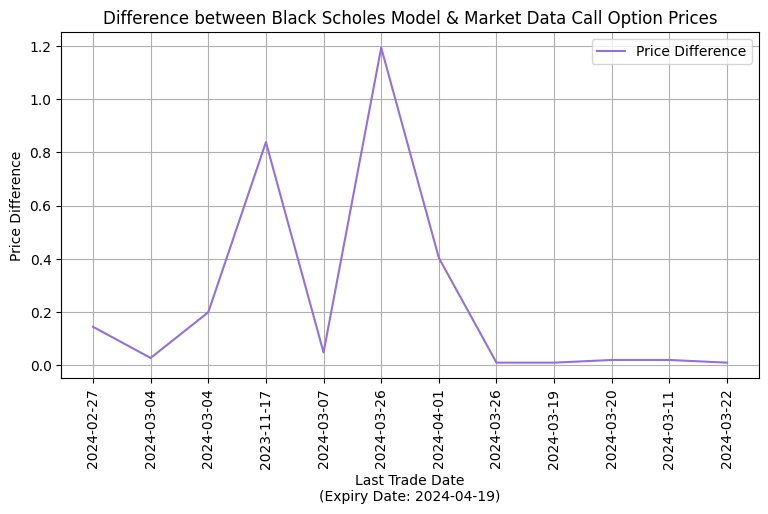

In [43]:
plt.figure(figsize=(9, 4.5))
differences = abs(calls['optionPriceBlackScholes'] - calls['lastPrice'])
plt.plot(calls.index, differences, label='Price Difference', c='mediumpurple')
plt.title('Difference between Black Scholes Model & Market Data Call Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

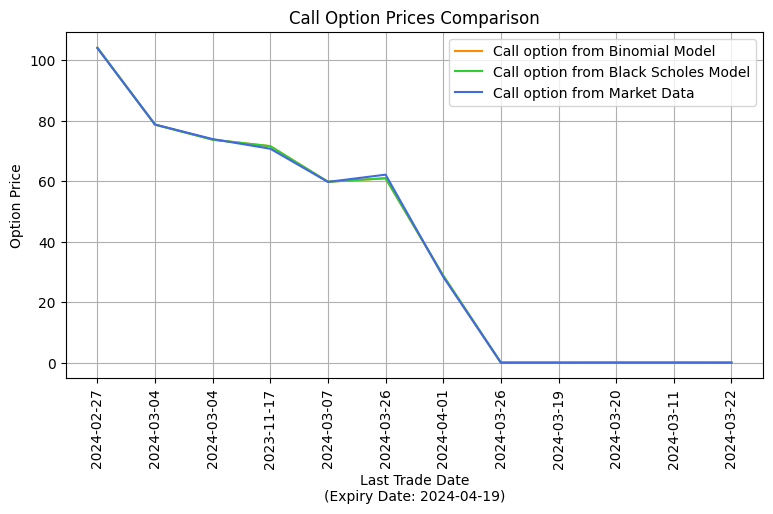

In [44]:
plt.figure(figsize=(9, 4.5))
plt.plot(calls.index, calls['optionPriceBinomial'], label='Call option from Binomial Model', c='darkorange')
plt.plot(calls.index, calls['optionPriceBlackScholes'], label='Call option from Black Scholes Model', c='limegreen')
plt.plot(calls.index, calls['lastPrice'], label='Call option from Market Data', c='royalblue')
plt.title('Call Option Prices Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(calls.index, calls.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

### Put Option Comparison

In [45]:
puts['lastTradeDate'] = pd.to_datetime(puts['lastTradeDate']).dt.date
start_date = "2023-03-28"
end_date = "2024-04-01"
puts = puts[(puts['lastTradeDate'] >= pd.to_datetime(start_date).date()) & (puts['lastTradeDate'] <= pd.to_datetime(end_date).date())]
puts.reset_index(inplace = True, drop = True)
puts.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-02-28,60.0,0.01,6.248049,REGULAR,USD
1,2024-02-23,65.0,0.02,4.429692,REGULAR,USD
2,2024-03-21,70.0,0.02,2.750003,REGULAR,USD
3,2024-03-11,75.0,0.02,2.500004,REGULAR,USD
4,2024-03-26,90.0,0.02,1.937500,REGULAR,USD


In [46]:
initialPrice_put = []
for date in puts['lastTradeDate']:
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    initialPrice_put.append(initialPrice)
puts['initialPrice'] = initialPrice_put

In [47]:
maturity_periods_put = []
for i in puts['lastTradeDate']:
    maturity_period = (expiry_date - i).days
    maturity_periods_put.append(maturity_period)

In [48]:
puts['maturityPeriod'] = maturity_periods_put
puts.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod
0,2024-02-28,60.0,0.01,6.248049,REGULAR,USD,136.380005,51
1,2024-02-23,65.0,0.02,4.429692,REGULAR,USD,143.960007,56
2,2024-03-21,70.0,0.02,2.750003,REGULAR,USD,147.600006,29
3,2024-03-11,75.0,0.02,2.500004,REGULAR,USD,137.669998,39
4,2024-03-26,90.0,0.02,1.937500,REGULAR,USD,150.669998,24


In [49]:
option_price_binomial = []
for i in range(len(puts)):
    T = puts['maturityPeriod'][i]/365
    n = puts['maturityPeriod'][i]
    K = puts['strike'][i]
    S0 = puts['initialPrice'][i]
    op_price = binomial_option_pricing(S0, K, T, r, σ, n, "put")
    option_price_binomial.append(op_price)

In [50]:
puts['optionPriceBinomial'] = option_price_binomial
puts

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial
0,2024-02-28,60.0,0.01,6.248049,REGULAR,USD,136.380005,51,0.000000
1,2024-02-23,65.0,0.02,4.429692,REGULAR,USD,143.960007,56,0.000000
2,2024-03-21,70.0,0.02,2.750003,REGULAR,USD,147.600006,29,0.000000
3,2024-03-11,75.0,0.02,2.500004,REGULAR,USD,137.669998,39,0.000000
4,2024-03-26,90.0,0.02,1.937500,REGULAR,USD,150.669998,24,0.000000
5,2024-01-30,185.0,32.73,5.081058,REGULAR,USD,151.460007,80,32.310718
6,2024-01-30,190.0,37.68,5.300540,REGULAR,USD,151.460007,80,37.027330
7,2024-02-14,200.0,54.90,5.004887,REGULAR,USD,145.940002,65,52.475703
8,2024-02-28,205.0,69.31,3.271486,REGULAR,USD,136.380005,51,67.329442


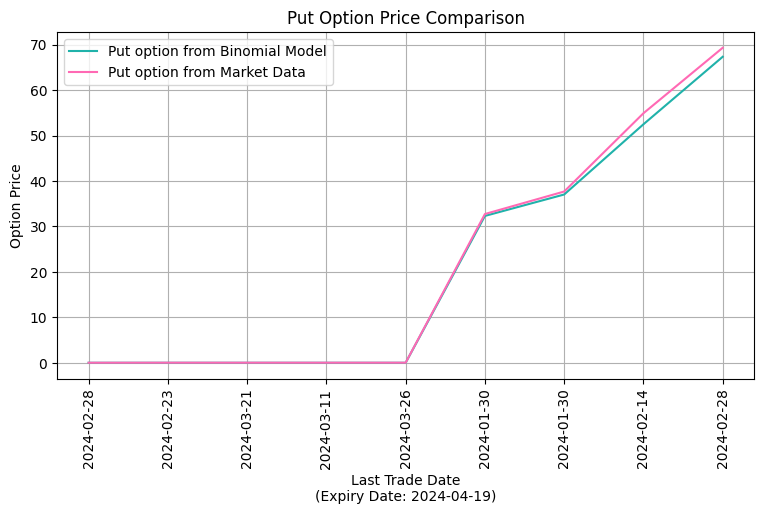

In [51]:
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, puts['optionPriceBinomial'], label='Put option from Binomial Model', c='lightseagreen')
plt.plot(puts.index, puts['lastPrice'], label='Put option from Market Data', c='hotpink')
plt.title('Put Option Price Comparison')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()
plt.show()

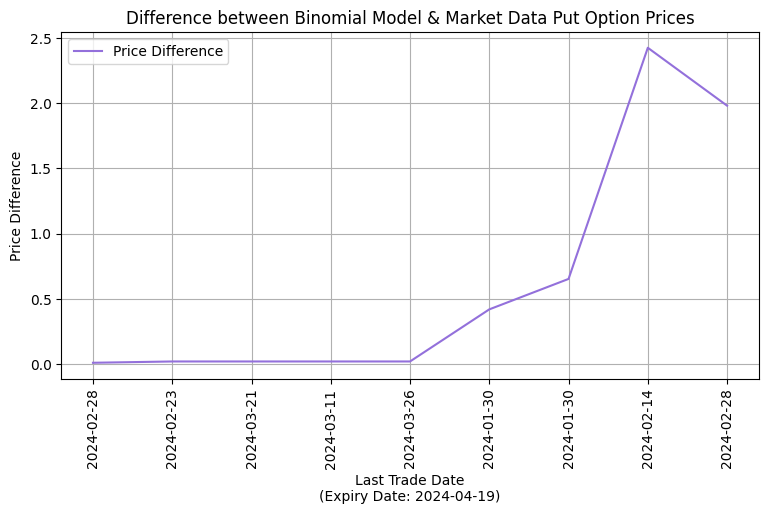

In [52]:
differences = abs(puts['optionPriceBinomial'] - puts['lastPrice'])
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, differences, label='Price Difference',  c='mediumpurple')
plt.title('Difference between Binomial Model & Market Data Put Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

In [53]:
option_price_black_scholes = []
for i in range(len(puts)):
    T = puts['maturityPeriod'][i]/365
    n = puts['maturityPeriod'][i]
    K = puts['strike'][i]
    S0 = puts['initialPrice'][i]
    op_price = black_scholes_formula(S0, K, T, r, σ, "put")
    option_price_black_scholes.append(op_price)

In [54]:
puts['optionPriceBlackScholes'] = option_price_black_scholes
puts.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initialPrice,maturityPeriod,optionPriceBinomial,optionPriceBlackScholes
0,2024-02-28,60.0,0.01,6.248049,REGULAR,USD,136.380005,51,0.0,-7.105427e-15
1,2024-02-23,65.0,0.02,4.429692,REGULAR,USD,143.960007,56,0.0,1.421085e-14
2,2024-03-21,70.0,0.02,2.750003,REGULAR,USD,147.600006,29,0.0,0.000000e+00
3,2024-03-11,75.0,0.02,2.500004,REGULAR,USD,137.669998,39,0.0,2.302158e-12
4,2024-03-26,90.0,0.02,1.937500,REGULAR,USD,150.669998,24,0.0,5.684342e-14


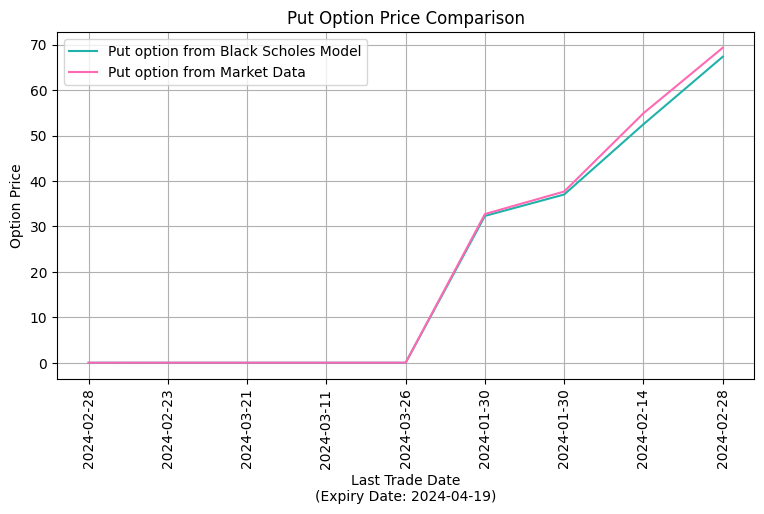

In [55]:
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, puts['optionPriceBinomial'], label='Put option from Black Scholes Model', c='lightseagreen')
plt.plot(puts.index, puts['lastPrice'], label='Put option from Market Data', c='hotpink')
plt.title('Put Option Price Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

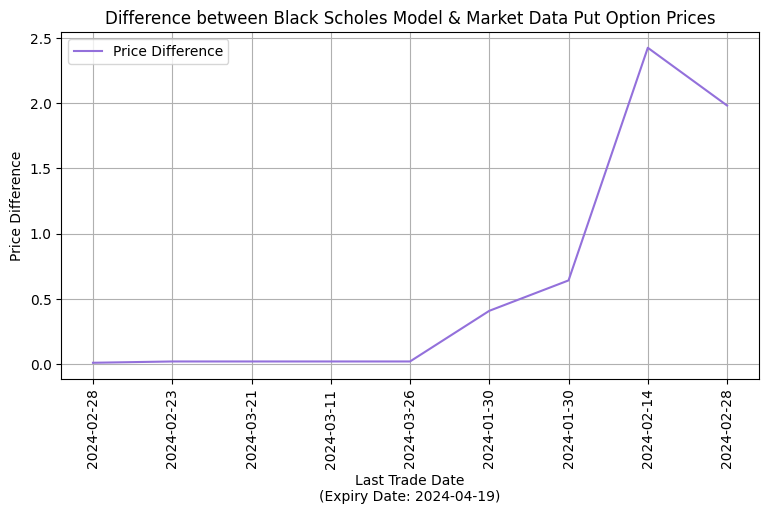

In [56]:
differences = abs(puts['optionPriceBlackScholes'] - puts['lastPrice'])
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, differences, label='Price Difference', c='mediumpurple')
plt.title('Difference between Black Scholes Model & Market Data Put Option Prices')
plt.ylabel('Price Difference')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

### Black Scholes vs Binomial vs Actual Market Data

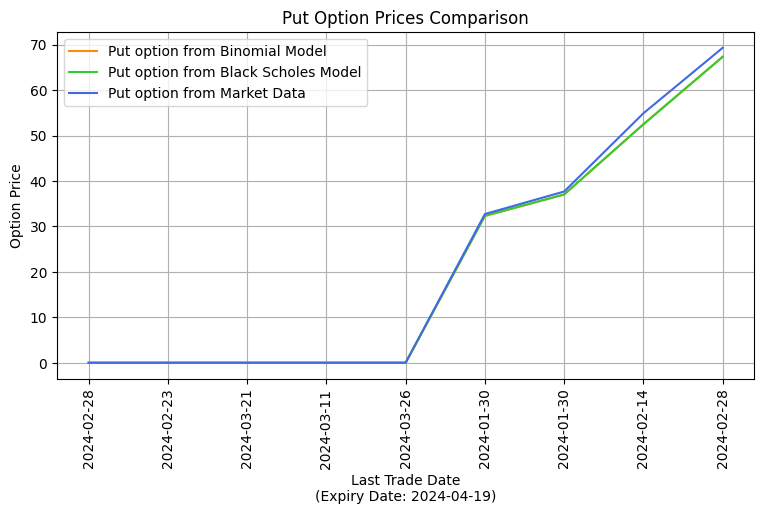

In [57]:
plt.figure(figsize=(9, 4.5))
plt.plot(puts.index, puts['optionPriceBinomial'], label='Put option from Binomial Model', c='darkorange')
plt.plot(puts.index, puts['optionPriceBlackScholes'], label='Put option from Black Scholes Model', c='limegreen')
plt.plot(puts.index, puts['lastPrice'], label='Put option from Market Data', c='royalblue')
plt.title('Put Option Prices Comparison')
plt.ylabel('Option Price')
plt.xlabel(f'Last Trade Date\n(Expiry Date: {expiry_date})')
plt.xticks(puts.index, puts.lastTradeDate, rotation='vertical')
plt.grid(True)
plt.legend()
plt.show()

## Delta Neutral Portfolio
---

In [58]:
def portfolio(S0, K, T, r, sigma, option='call', batch_size = 10):
    d1 = (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    curr_delta = delta * batch_size

    if option == 'call':
        x = (batch_size * delta) / (1 - delta)
    elif option == 'put':
        x = (batch_size * (1 - delta)) / delta
        delta = delta - 1

    return x , delta

In [59]:
portfolio_call, delta_call = [], []
for i in range(len(calls)):
    date = calls.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = portfolio(initialPrice, calls.loc[i, 'strike'], calls.loc[i, 'maturityPeriod'], r, σ, option='call')
    portfolio_call.append(temp[0])
    delta_call.append(temp[1])

portfolio_put, delta_put = [], []
for i in range(len(puts)):
    date = puts.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = portfolio(initialPrice, puts.loc[i, 'strike'], puts.loc[i, 'maturityPeriod'], r, σ, option='put')
    portfolio_put.append(temp[0])
    delta_put.append(temp[1])

In [60]:
call_table = pd.DataFrame({
    'Strike (K)': calls['strike'],
    'Time to Maturity (T in days)': calls['maturityPeriod'],
    'Risk-Free Rate (r)': r,
    'Volatility (σ)': σ,
    'Call Delta': delta_call,
    'Portfolio (number of put options)': portfolio_call
})
call_table

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Call Delta,Portfolio (number of put options)
0,35.0,52,0.0452,0.269533,0.998075,5185.122445
1,55.0,46,0.0452,0.269533,0.994392,1773.096783
2,60.0,46,0.0452,0.269533,0.993582,1548.106548
3,65.0,154,0.0452,0.269533,0.999964,281406.907250
4,75.0,43,0.0452,0.269533,0.989648,956.017996
5,90.0,24,0.0452,0.269533,0.969397,316.763078
6,127.0,18,0.0452,0.269533,0.927887,128.672170
7,215.0,24,0.0452,0.269533,0.887340,78.762346
8,220.0,31,0.0452,0.269533,0.921541,117.454770
9,225.0,30,0.0452,0.269533,0.915635,108.533112


In [61]:
call_table = call_table.applymap('{:.6f}'.format)
call_table

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Call Delta,Portfolio (number of put options)
0,35.000000,52.000000,0.045200,0.269533,0.998075,5185.122445
1,55.000000,46.000000,0.045200,0.269533,0.994392,1773.096783
2,60.000000,46.000000,0.045200,0.269533,0.993582,1548.106548
3,65.000000,154.000000,0.045200,0.269533,0.999964,281406.907250
4,75.000000,43.000000,0.045200,0.269533,0.989648,956.017996
5,90.000000,24.000000,0.045200,0.269533,0.969397,316.763078
6,127.000000,18.000000,0.045200,0.269533,0.927887,128.672170
7,215.000000,24.000000,0.045200,0.269533,0.887340,78.762346
8,220.000000,31.000000,0.045200,0.269533,0.921541,117.454770
9,225.000000,30.000000,0.045200,0.269533,0.915635,108.533112


In [62]:
put_data = pd.DataFrame({
    'Strike (K)': puts['strike'],
    'Time to Maturity (T in days)': puts['maturityPeriod'],
    'Risk-Free Rate (r)': r,
    'Volatility (σ)': σ,
    'Put Delta': delta_put,
    'Portfolio (number of call options)': portfolio_put
})
put_data

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Put Delta,Portfolio (number of call options)
0,60.0,51,0.0452,0.269533,-0.004846,0.048699
1,65.0,56,0.0452,0.269533,-0.003934,0.039498
2,70.0,29,0.0452,0.269533,-0.016065,0.163275
3,75.0,39,0.0452,0.269533,-0.012233,0.123848
4,90.0,24,0.0452,0.269533,-0.030603,0.315693
5,185.0,80,0.0452,0.269533,-0.004366,0.043855
6,190.0,80,0.0452,0.269533,-0.004510,0.045306
7,200.0,65,0.0452,0.269533,-0.010909,0.110291
8,205.0,51,0.0452,0.269533,-0.025690,0.263678


In [63]:
put_data = put_data.applymap('{:.6f}'.format)
put_data

,Strike (K),Time to Maturity (T in days),Risk-Free Rate (r),Volatility (σ),Put Delta,Portfolio (number of call options)
0,60.000000,51.000000,0.045200,0.269533,-0.004846,0.048699
1,65.000000,56.000000,0.045200,0.269533,-0.003934,0.039498
2,70.000000,29.000000,0.045200,0.269533,-0.016065,0.163275
3,75.000000,39.000000,0.045200,0.269533,-0.012233,0.123848
4,90.000000,24.000000,0.045200,0.269533,-0.030603,0.315693
5,185.000000,80.000000,0.045200,0.269533,-0.004366,0.043855
6,190.000000,80.000000,0.045200,0.269533,-0.004510,0.045306
7,200.000000,65.000000,0.045200,0.269533,-0.010909,0.110291
8,205.000000,51.000000,0.045200,0.269533,-0.025690,0.263678


## Implied Volatility
---

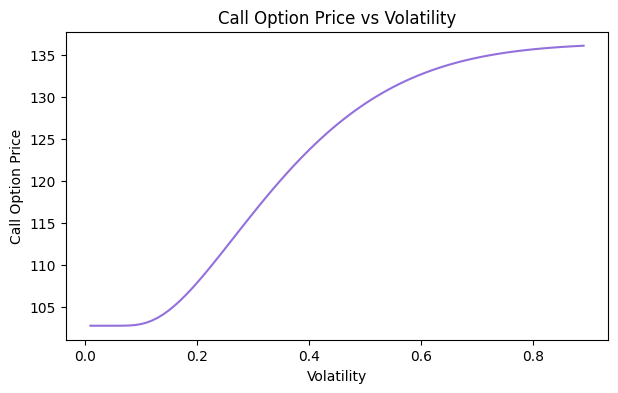

In [64]:
σs = np.arange(0.01, 0.9, 0.01)
C = [black_scholes_formula(S0, K, 40, r, σ, "call") for σ in σs]

plt.figure(figsize=(7, 4))
plt.plot(σs, C, c='mediumpurple')
plt.title("Call Option Price vs Volatility")
plt.xlabel("Volatility")
plt.ylabel("Call Option Price")
plt.show()

In [65]:
def newton_raphson(function, initial_guess, tolerance=1e-6, max_iterations=100, dh=1e-6):
    '''
    finds root of a function using newton-raphson method
    '''
    x = initial_guess
    for _ in range(max_iterations):
        fx = function(x)
        if abs(fx) < tolerance:
            return x
        dfx = (function(x + dh) - function(x)) / dh
        if dfx == 0:
            break
        x = x - fx / (dfx + 1e-6)
        if x < 0:
            x = dh
    return x

In [66]:
def implied_volatitlity(S0, K, r, T, CP, option='call'):
    def H(σ):
        return (black_scholes_formula(S0, K, T, r, σ, option) - CP)**2

    val = newton_raphson(H, 1.0)
    if np.abs(H(val) - H(0.0)) < 1e-5:
        return 0.0
    return val * 100

In [67]:
call_volatility = []
for i in range(len(calls)):
    date = calls.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = implied_volatitlity(initialPrice, calls.loc[i, 'strike'], r, calls.loc[i, 'maturityPeriod']/365, calls.loc[i, 'lastPrice'], option='call')
    call_volatility.append(temp)
    
put_volatility = []
for i in range(1, len(puts)):
    date = puts.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initialPrice = google_data.loc[date, 'Close']
    temp = implied_volatitlity(initialPrice, puts.loc[i, 'strike'], r, puts.loc[i, 'maturityPeriod']/365, puts.loc[i, 'lastPrice'], option='put')
    put_volatility.append(temp)

In [68]:
call_data = calls[['strike', 'lastPrice', 'maturityPeriod']].copy()
call_data.rename(columns={'strike': 'K', 'lastPrice': 'C', 'maturityPeriod': 'T'}, inplace=True)
call_data['S0'] = [google_data.loc[pd.to_datetime(date).strftime("%Y-%m-%d"), 'Close'] for date in calls['lastTradeDate']]
call_data['r'] = r
call_data['Implied Volatility(%)'] = call_volatility

In [69]:
call_data

,K,C,T,S0,r,Implied Volatility(%)
0,35.0,103.96,52,138.880005,0.0452,0.000000
1,55.0,78.69,46,133.350006,0.0452,92.549613
2,60.0,73.89,46,133.350006,0.0452,106.416472
3,65.0,70.70,154,135.309998,0.0452,0.000000
4,75.0,59.73,43,134.380005,0.0452,0.000000
5,90.0,62.13,24,150.669998,0.0452,135.459682
6,127.0,28.37,18,155.490005,0.0452,0.000000
7,215.0,0.01,24,150.669998,0.0452,47.049792
8,220.0,0.01,31,147.029999,0.0452,46.229409
9,225.0,0.02,30,148.740005,0.0452,51.195372


In [70]:
put_data = puts[['strike', 'lastPrice', 'maturityPeriod']].iloc[1:, :].copy()
put_data.rename(columns={'strike': 'K', 'lastPrice': 'P', 'maturityPeriod': 'T'}, inplace=True)
put_data['S0'] = [google_data.loc[pd.to_datetime(date).strftime("%Y-%m-%d"), 'Close'] for date in puts['lastTradeDate'].iloc[1:]]
put_data['r'] = r
put_data['Implied Volatility(%)'] = put_volatility

In [71]:
put_data

,K,P,T,S0,r,Implied Volatility(%)
1,65.0,0.02,56,143.960007,0.0452,73.036732
2,70.0,0.02,29,147.600006,0.0452,94.986516
3,75.0,0.02,39,137.669998,0.0452,68.321246
4,90.0,0.02,24,150.669998,0.0452,73.945618
5,185.0,32.73,80,151.460007,0.0452,30.530998
6,190.0,37.68,80,151.460007,0.0452,33.555262
7,200.0,54.90,65,145.940002,0.0452,60.743598
8,205.0,69.31,51,136.380005,0.0452,79.217592


---